In [8]:
import numpy as np
import tensorflow as tf
import os

assert tf.__version__ == "2.0.0-beta1", "Check tensorflow version. Should be 2.0.0-beta1."

In [9]:
try:
    gpu = tf.config.experimental.list_physical_devices('GPU')[0]
    tf.config.experimental.set_memory_growth(gpu, True)
except RuntimeError as error:
    print('This config has already been invoked. Error message:')
    print(error)

In [10]:
def check_songs(sources_all, mixtures_all):
    for ix, song in enumerate(sources_all):
        song = song.replace("Sources", "Mixtures")
        song = song.replace("vocals", "mixture")
        if song != mixtures_all[ix]:
            print(f"Index {ix} with song name '{song}' does not match.")
            raise TypeError
        else:
            continue
    print("Songs are in the right order.")

In [11]:
sources_all = np.array(['Data/Sources/'+s+'/vocals.wav' for s in os.listdir('Data/Sources')])
mixtures_all = np.array(['Data/Mixtures/'+s+'/mixture.wav' for s in os.listdir('Data/Mixtures')])

sources_data, sources_listen = np.array(sources_all[:90]), np.array(sources_all[90:])
mixtures_data, mixtures_listen = np.array(mixtures_all[:90]), np.array(mixtures_all[90:])

print("Checking song order...\n")

check_songs(sources_all, mixtures_all)
check_songs(sources_data, mixtures_data)
check_songs(sources_listen, mixtures_listen)

print()
print(f"Total songs: {len(sources_all)}. Total data: {len(sources_data)}. Total listening: {len(sources_listen)}.")

Checking song order...

Songs are in the right order.
Songs are in the right order.
Songs are in the right order.

Total songs: 99. Total data: 90. Total listening: 9.


In [5]:
@tf.function
def get_song_stft(source, mixture, frame_length=2048, frame_step=512):
    
    source_string = tf.io.read_file(tf.convert_to_tensor(source, dtype=tf.string))
    mixture_string = tf.io.read_file(tf.convert_to_tensor(source, dtype=tf.string))
    
    decoded_source, _ = tf.audio.decode_wav(source_string)
    decoded_mixture, _ = tf.audio.decode_wav(mixture_string)
    
    decoded_source_norm = decoded_source[:,0] / tf.reduce_max(decoded_source[:,0])
    decoded_mixture_norm = decoded_mixture[:,0] / tf.reduce_max(decoded_mixture[:,0])
    
    decoded_source_stft = tf.abs(tf.signal.stft(decoded_source_norm, frame_length=frame_length, frame_step=frame_step))
    decoded_mixture_stft = tf.abs(tf.signal.stft(decoded_mixture_norm, frame_length=frame_length, frame_step=frame_step))
    
    return decoded_source_stft, decoded_mixture_stft


def get_temporal_context(source_stft, mixture_stft, context_len=15, dtype=np.float16):
    
    source_stft_contexts, mixture_stft_contexts = [], []
    
    assert len(source_stft) == len(mixture_stft), "The source and mixture do not match length."
    assert context_len % 2 != 0, "The context window must be odd."
    
    for ix in range(0,len(source_stft)-context_len, context_len):
        single_source_context = source_stft[ix+(int((context_len-1)/2))]
        single_mixture_context = mixture_stft[ix:ix+context_len]
        
        source_stft_contexts.append(single_source_context)
        mixture_stft_contexts.append(single_mixture_context)
        
    source_stft_contexts = np.expand_dims(np.stack(source_stft_contexts).astype(dtype), 1)
    mixture_stft_contexts = np.stack(mixture_stft_contexts).astype(dtype)
    
    return source_stft_contexts, mixture_stft_contexts


def get_data(sources, mixtures, dtype=np.float16, mem_limit=2.0):
    
    all_sources, all_mixtures = [], []
    song_iter = 1
    mem_usage = 0
    
    for source, mixture in zip(sources, mixtures):
        
        try:
            source_stft, mixture_stft = get_song_stft(tf.cast(source, dtype=tf.string),
                                                      tf.cast(mixture, dtype=tf.string),
                                                      frame_length=2048,
                                                      frame_step=512)

            source_context, mixture_context = get_temporal_context(np.array(source_stft),
                                                                   np.array(mixture_stft),
                                                                   context_len=15,
                                                                   dtype=np.float16)
        except:
            print(f"\nSong {source} not found. Skipping...\n")
            song_iter += 1
            continue
        
        all_sources.append(source_context)
        all_mixtures.append(mixture_context)
        
        song_mem_usage = source_context.nbytes + mixture_context.nbytes
        mem_usage += song_mem_usage
        
        print(f"STFT no: {song_iter}/{len(sources)}.",\
              f"STFT memory usage: {np.round(song_mem_usage*1e-6, 1)} MB.",\
              f"Total memory usage: {np.round(mem_usage*1e-9, 1)}/{mem_limit} GB.")
        
        song_iter += 1
        
        if mem_usage*1e-9 > mem_limit:
            print(f"\nMemory limit exceeded. Returning {len(all_sources)} songs...")
            break

    all_sources = np.expand_dims(np.concatenate(all_sources), -1)
    all_mixtures = np.expand_dims(np.concatenate(all_mixtures), -1)
    
    return all_sources, all_mixtures

In [27]:
all_data_sources, all_data_mixtures = get_data(sources_data, mixtures_data, mem_limit=16.0)

STFT no: 1/90. STFT memory usage: 44.8 MB. Total memory usage: 0.0/16.0 GB.
STFT no: 2/90. STFT memory usage: 31.2 MB. Total memory usage: 0.1/16.0 GB.
STFT no: 3/90. STFT memory usage: 30.8 MB. Total memory usage: 0.1/16.0 GB.
STFT no: 4/90. STFT memory usage: 37.8 MB. Total memory usage: 0.1/16.0 GB.
STFT no: 5/90. STFT memory usage: 39.7 MB. Total memory usage: 0.2/16.0 GB.
STFT no: 6/90. STFT memory usage: 50.5 MB. Total memory usage: 0.2/16.0 GB.
STFT no: 7/90. STFT memory usage: 41.4 MB. Total memory usage: 0.3/16.0 GB.
STFT no: 8/90. STFT memory usage: 43.5 MB. Total memory usage: 0.3/16.0 GB.
STFT no: 9/90. STFT memory usage: 41.7 MB. Total memory usage: 0.4/16.0 GB.
STFT no: 10/90. STFT memory usage: 47.1 MB. Total memory usage: 0.4/16.0 GB.
STFT no: 11/90. STFT memory usage: 55.5 MB. Total memory usage: 0.5/16.0 GB.
STFT no: 12/90. STFT memory usage: 43.8 MB. Total memory usage: 0.5/16.0 GB.
STFT no: 13/90. STFT memory usage: 67.2 MB. Total memory usage: 0.6/16.0 GB.
STFT no:

In [28]:
np.save("sources_train.npy", all_data_sources)
np.save("mixtures_train.npy", all_data_mixtures)

In [12]:
all_data_sources = np.load("sources_train.npy")
all_data_mixtures = np.load("mixtures_train.npy")

In [13]:
print("Sources shape:", all_data_sources.shape)
print("Mixtures shape:", all_data_mixtures.shape)
full_data_len = len(all_data_sources)

Sources shape: (127303, 1, 1025, 1)
Mixtures shape: (127303, 15, 1025, 1)


In [14]:
from sklearn.model_selection import train_test_split

def make_dataset(X, y, batch_size=256):
    
    dataset = tf.data.Dataset.from_tensor_slices((X, y))

    dataset = dataset.shuffle(full_data_len)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

mixture_train, mixture_val, source_train, source_val = train_test_split(all_data_mixtures,
                                                                          all_data_sources,
                                                                          test_size=0.2,
                                                                          random_state=42)

data_train = make_dataset(mixture_train, source_train, 256)
data_val = make_dataset(mixture_val, source_val, 256)

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

autoencoder = Sequential(name='Basic_Autoencoder')

autoencoder.add(layers.Conv2D(30, (3, 3), activation='relu', padding='same', input_shape=(15, 1025, 1)))
autoencoder.add(layers.MaxPooling2D((3, 5)))
autoencoder.add(layers.Conv2D(60, (1, 1), activation='relu', padding='same'))
autoencoder.add(layers.MaxPooling2D((1, 5)))
autoencoder.add(layers.Conv2D(60, (1, 1), activation='relu', padding='same'))
autoencoder.add(layers.Conv2D(120, (1, 1), activation='relu', padding='same'))
autoencoder.add(layers.MaxPooling2D((5, 1)))
autoencoder.add(layers.Conv2D(120, (1, 1), activation='relu', padding='same'))
autoencoder.add(layers.Conv2D(60, (1, 1), activation='relu', padding='same'))
autoencoder.add(layers.UpSampling2D((1, 5)))
autoencoder.add(layers.Conv2D(30, (3,3), activation='relu', padding='same'))
autoencoder.add(layers.UpSampling2D((1, 5)))
autoencoder.add(layers.Conv2D(1, (1, 1), activation='relu', padding='same'))

autoencoder.compile('adam', 'mean_squared_error')

In [16]:
autoencoder.summary()

Model: "Basic_Autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 15, 1025, 30)      300       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 5, 205, 30)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 5, 205, 60)        1860      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 41, 60)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 41, 60)         3660      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 41, 120)        7320      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 1, 41, 120)  

In [18]:
history = autoencoder.fit(data_train, epochs=10, validation_data=data_val)

Epoch 1/10
398/398 [==============================] - 58s 146ms/step - loss: 6.6792 - val_loss: 6.6091
Epoch 2/10
398/398 [==============================] - 60s 150ms/step - loss: 6.3467 - val_loss: 6.5896
Epoch 3/10
398/398 [==============================] - 63s 158ms/step - loss: 6.2637 - val_loss: 6.4814
Epoch 4/10
398/398 [==============================] - 63s 159ms/step - loss: 6.2061 - val_loss: 6.4097
Epoch 5/10
398/398 [==============================] - 61s 153ms/step - loss: 6.1633 - val_loss: 6.3640
Epoch 6/10
398/398 [==============================] - 62s 157ms/step - loss: 6.1264 - val_loss: 6.3251
Epoch 7/10
398/398 [==============================] - 58s 147ms/step - loss: 6.0972 - val_loss: 6.3110
Epoch 8/10
398/398 [==============================] - 62s 156ms/step - loss: 6.0690 - val_loss: 6.2753
Epoch 9/10
398/398 [==============================] - 63s 158ms/step - loss: 6.0454 - val_loss: 6.2670
Epoch 10/10
398/398 [==============================] - 60s 149ms/step - l

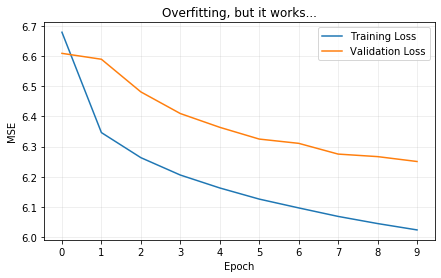

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(7, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xticks(np.arange(0, 10))
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title("Overfitting, but it works...")

plt.grid(True, alpha=0.25)
plt.legend(loc='upper right')
plt.show()